In [1]:
import numpy as np
import pandas as pd
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import pickle as pkl
from pandas.plotting import autocorrelation_plot


# Load Datasets

In [2]:
df_hr_2 = pd.read_csv('panel_regr_data_hr_2.csv')
df_hrv_2 = pd.read_csv('panel_regr_data_hrv_2.csv')
df_hr_3 = pd.read_csv('panel_regr_data_hr_3.csv')
df_hrv_3 = pd.read_csv('panel_regr_data_hrv_3.csv')

In [3]:

with open('v2_participant_nums.pkl', 'rb') as f:
    v2_participant_nums = pkl.load(f)
    
with open('v3_participant_nums.pkl', 'rb') as f:
    v3_participant_nums = pkl.load(f)
    
    
    reaction_strength = {
    'No Reaction': v3_participant_nums[2],
    'Mild Reaction': v3_participant_nums[1],
    'Severe Reaction': v3_participant_nums[0],
}

# ACF Plot on 3rd Vaccine (Everyone)

In [4]:
def plot_acfs(df, label, text_label):
    parts = list(set(df['participant_num'].values))

    acfs = np.zeros((len(parts), 336))
    diffs = np.zeros((len(parts), 335))
    pacfs = np.zeros((len(parts), 26))
    
    for i in range(len(parts)):
        part = parts[i]
        s = df[df['participant_num']==part][label]
        acfs[i] = sm.tsa.acf(s, nlags = 336)
        pacfs[i] = sm.tsa.pacf(s)
        s = s.diff().iloc[1:] #First order difference to de-trend
        diffs[i] = sm.tsa.acf(s, nlags = 335)
        
    acf = np.nanmean(acfs, axis=0)
    pacf = np.nanmean(pacfs, axis=0)
    diff = np.nanmean(diffs, axis=0)
    
    # Plot autocorrelation plot
    plt.figure(figsize=(6,4))
    plt.axhline(2.57/np.sqrt(336), color='gray', linestyle='dashed', label='99% CI')
    plt.axhline(-2.57/np.sqrt(336), color='gray', linestyle='dashed')
    plt.plot(np.arange(1, 336), acf[1:], color='blue', label='Autocorrelation')
    plt.xticks(np.arange(0, 337, 24))
    plt.yticks(np.arange(-1, 1.1, 0.25))
    plt.xlabel("Lag (hours)")
    plt.ylabel("Autocorrelation")
    plt.title("Hourly %s after 3rd Vaccination" % (text_label))
    plt.legend()
    plt.show()
    
    # Plot diffed autocorrelation plot
    plt.figure(figsize=(6,4))
    plt.axhline(2.57/np.sqrt(336), color='gray', linestyle='dashed', label='99% CI')
    plt.axhline(-2.57/np.sqrt(336), color='gray', linestyle='dashed')
    plt.plot(np.arange(1, 335), diff[1:], color='blue', label='Autocorrelation')
    plt.xticks(np.arange(0, 337, 24))
    plt.yticks(np.arange(-1, 1.1, 0.25))
    plt.xlabel("Lag (hours)")
    plt.ylabel("Autocorrelation")
    plt.title("Diffed Hourly %s after 3rd Vaccination" % (text_label))
    plt.legend()
    plt.show()
    
    # Plot partial autocorrelation plot
    plt.figure(figsize=(6,4))
    plt.axhline(2.57/np.sqrt(336), color='gray', linestyle='dashed', label='99% CI')
    plt.axhline(-2.57/np.sqrt(336), color='gray', linestyle='dashed')
    plt.plot(np.arange(1, 26), pacf[1:], color='red', label='Partial Autocorrelation')
    plt.yticks(np.arange(-1, 1.1, 0.25))
    plt.xlabel("Lag (hours)")
    plt.ylabel("Partial Autocorrelation")
    plt.title("Hourly %s after 3rd Vaccination" % (text_label))
    plt.legend()
    plt.show()

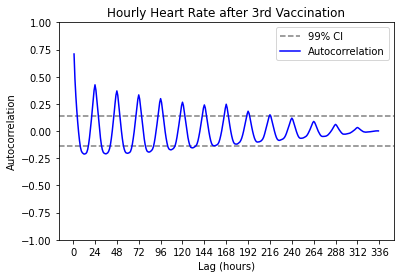

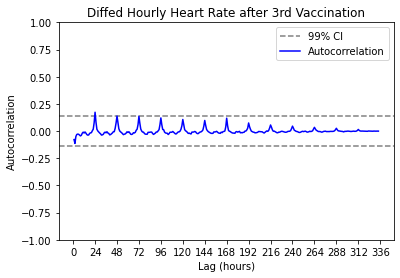

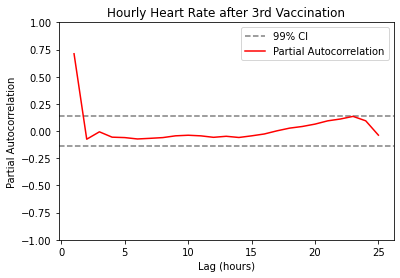

In [5]:
plot_acfs(df_hr_3, 'hr', 'Heart Rate')

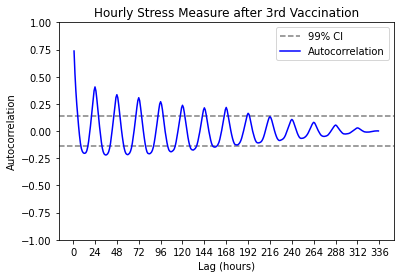

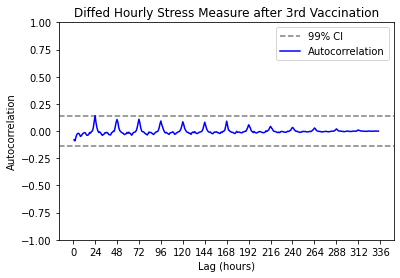

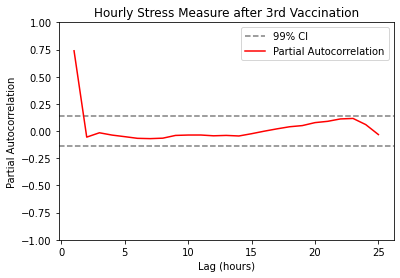

In [6]:
plot_acfs(df_hrv_3, 'hrv', 'Stress Measure')

# Run Panel Regression on DF

In [7]:
def panel_regression(df, dep_var):
    dep_var
    
    
    df['gender'] = pd.Categorical(df['gender'])
    df['healthy'] = pd.Categorical(df['healthy'])
    df['vaccine_day'] = pd.Categorical(df['vaccine_day'])
    df['vaccine_hour'] = pd.Categorical(df['vaccine_hour'])

    participant_num = df.participant_num
    time = df.time

    df['%s_residual' % (dep_var)] = 0
    
    df['%s_offset_1' % (dep_var)] = df.groupby(['participant_num'])[dep_var].shift(1).fillna(0)
    
    df = df.set_index(['participant_num', 'time'])
    df['participant_num'] = pd.Categorical(participant_num)
    df['time'] = pd.Categorical(time)

    ##############################################################################

    X = df[['age', 'gender', 'healthy']]
    Y = df[dep_var]

    first_model = smf.ols(formula="%s ~ age + C(gender) + C(healthy) - 1" % (dep_var), data=df).fit()

    preds = Y - first_model.predict(X)

    df.loc[preds.index, '%s_residual' % (dep_var)] = preds
    
    print(first_model.summary())
    
    ##############################################################################
    
    fixed_effects_model = PanelOLS.from_formula("%s_residual ~ %s_offset_1 + after_vaccination + EntityEffects" % (dep_var, dep_var), data=df)
    print(fixed_effects_model.fit())
    
    ##############################################################################
    
    exog_vars = ['%s_offset_1' % (dep_var), 'after_vaccination']
    exog = sm.add_constant(df[exog_vars])
    random_effects_model = RandomEffects(df['%s_residual' % (dep_var)],  exog)
    re_res = random_effects_model.fit()
    
    print(re_res.variance_decomposition)
    print(print(re_res))
    #re_res.theta.head()

    return first_model, fixed_effects_model, random_effects_model

In [8]:
# 3rd vaccine - everyone - hr

df = df_hr_3
df['after_vaccination'] = (df['time'] >= 0) & (df['time'] <= 24*3)
print(len(set(df_hr_3['participant_num'].values)))
panel_regression(df, 'hr')

1121
                            OLS Regression Results                            
Dep. Variable:                     hr   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     3551.
Date:                Wed, 31 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:40:58   Log-Likelihood:            -1.1749e+06
No. Observations:              289242   AIC:                         2.350e+06
Df Residuals:                  289238   BIC:                         2.350e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
C(gender)[Female]     85.3896  

/opt/anaconda3/lib/python3.8/site-packages/linearmodels/panel/model.py:1184: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:            hr_residual   R-squared:                        0.3482
Estimator:                   PanelOLS   R-squared (Between):             -18.737
No. Observations:              289242   R-squared (Within):               0.3482
Date:                Wed, Aug 31 2022   R-squared (Overall):             -5.9630
Time:                        20:40:59   Log-likelihood                -1.059e+06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   7.696e+04
Entities:                        1070   P-value                           0.0000
Avg Obs:                       270.32   Distribution:                F(2,288170)
Min Obs:                       6.0000                                           
Max Obs:                       336.00   F-statistic (robust):          7.696e+04
                            

/opt/anaconda3/lib/python3.8/site-packages/linearmodels/panel/model.py:2575: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Effects                    8.154184
Residual                  89.165215
Percent due to Effects     0.083788
Name: Variance Decomposition, dtype: float64
                        RandomEffects Estimation Summary                        
Dep. Variable:            hr_residual   R-squared:                        0.3539
Estimator:              RandomEffects   R-squared (Between):              0.6718
No. Observations:              289242   R-squared (Within):               0.3481
Date:                Wed, Aug 31 2022   R-squared (Overall):              0.4535
Time:                        20:41:00   Log-likelihood                -1.061e+06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   7.922e+04
Entities:                        1070   P-value                           0.0000
Avg Obs:                       270.32   Distribution:                F(2,289239)
Min Obs:                       6.0000

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f1002877610>,
 PanelOLS 
 Num exog: 2, Constant: False
 Entity Effects: True, Time Effects: False, Num Other Effects: 0
 id: 0x7f10028857f0,
 RandomEffects 
 Num exog: 3, Constant: True
 id: 0x7f1002885250)

In [9]:
# 3rd vaccine - everyone - hrv

df = df_hrv_3
df['after_vaccination'] = (df['time'] >= 0) & (df['time'] <= 24*3)

panel_regression(df, 'hrv')

                            OLS Regression Results                            
Dep. Variable:                    hrv   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1695.
Date:                Wed, 31 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:41:05   Log-Likelihood:            -1.2794e+06
No. Observations:              285238   AIC:                         2.559e+06
Df Residuals:                  285234   BIC:                         2.559e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
C(gender)[Female]     40.9776      0

/opt/anaconda3/lib/python3.8/site-packages/linearmodels/panel/model.py:1184: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:           hrv_residual   R-squared:                        0.5595
Estimator:                   PanelOLS   R-squared (Between):             -9.8890
No. Observations:              285238   R-squared (Within):               0.5595
Date:                Wed, Aug 31 2022   R-squared (Overall):             -0.6892
Time:                        20:41:06   Log-likelihood                -1.148e+06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   1.805e+05
Entities:                        1063   P-value                           0.0000
Avg Obs:                       268.33   Distribution:                F(2,284173)
Min Obs:                       6.0000                                           
Max Obs:                       336.00   F-statistic (robust):          1.805e+05
                            

/opt/anaconda3/lib/python3.8/site-packages/linearmodels/panel/model.py:2575: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Effects                     6.743405
Residual                  183.483990
Percent due to Effects      0.035449
Name: Variance Decomposition, dtype: float64
                        RandomEffects Estimation Summary                        
Dep. Variable:           hrv_residual   R-squared:                        0.5623
Estimator:              RandomEffects   R-squared (Between):              0.8315
No. Observations:              285238   R-squared (Within):               0.5595
Date:                Wed, Aug 31 2022   R-squared (Overall):              0.5865
Time:                        20:41:07   Log-likelihood                -1.148e+06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   1.832e+05
Entities:                        1063   P-value                           0.0000
Avg Obs:                       268.33   Distribution:                F(2,285235)
Min Obs:                       6.0

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f100295e160>,
 PanelOLS 
 Num exog: 2, Constant: False
 Entity Effects: True, Time Effects: False, Num Other Effects: 0
 id: 0x7f10028dab50,
 RandomEffects 
 Num exog: 3, Constant: True
 id: 0x7f100295e490)

In [10]:
# 3rd vaccine - asymptomatic - hr

df = df_hr_3
df['participant_num'] = df['participant_num'].astype(str)
df = df[df['participant_num'].isin(v3_participant_nums[2])]
df['after_vaccination'] = (df['time'] >= 0) & (df['time'] <= 24*3)

panel_regression(df, 'hr')

/tmp/ipykernel_542839/3867032103.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['after_vaccination'] = (df['time'] >= 0) & (df['time'] <= 24*3)
/tmp/ipykernel_542839/685371717.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender'] = pd.Categorical(df['gender'])
/tmp/ipykernel_542839/685371717.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

                            OLS Regression Results                            
Dep. Variable:                     hr   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1402.
Date:                Wed, 31 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:41:11   Log-Likelihood:            -5.7411e+05
No. Observations:              141869   AIC:                         1.148e+06
Df Residuals:                  141865   BIC:                         1.148e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
C(gender)[Female]     85.0400      0

/opt/anaconda3/lib/python3.8/site-packages/linearmodels/panel/model.py:1184: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:            hr_residual   R-squared:                        0.3399
Estimator:                   PanelOLS   R-squared (Between):             -18.321
No. Observations:              141869   R-squared (Within):               0.3399
Date:                Wed, Aug 31 2022   R-squared (Overall):             -5.8062
Time:                        20:41:11   Log-likelihood                -5.186e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                    3.64e+04
Entities:                         523   P-value                           0.0000
Avg Obs:                       271.26   Distribution:                F(2,141344)
Min Obs:                       6.0000                                           
Max Obs:                       336.00   F-statistic (robust):           3.64e+04
                            

/opt/anaconda3/lib/python3.8/site-packages/linearmodels/panel/model.py:2575: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Effects                    6.981306
Residual                  87.985251
Percent due to Effects     0.073513
Name: Variance Decomposition, dtype: float64
                        RandomEffects Estimation Summary                        
Dep. Variable:            hr_residual   R-squared:                        0.3464
Estimator:              RandomEffects   R-squared (Between):              0.6635
No. Observations:              141869   R-squared (Within):               0.3399
Date:                Wed, Aug 31 2022   R-squared (Overall):              0.4449
Time:                        20:41:13   Log-likelihood                -5.193e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                    3.76e+04
Entities:                         523   P-value                           0.0000
Avg Obs:                       271.26   Distribution:                F(2,141866)
Min Obs:                       6.0000

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f1002908d60>,
 PanelOLS 
 Num exog: 2, Constant: False
 Entity Effects: True, Time Effects: False, Num Other Effects: 0
 id: 0x7f100290f5b0,
 RandomEffects 
 Num exog: 3, Constant: True
 id: 0x7f100297cdc0)

In [11]:
# 3rd vaccine - asymptomatic - hrv

df = df_hrv_3
df['participant_num'] = df['participant_num'].astype(str)
df = df[df['participant_num'].isin(v3_participant_nums[2])]
df['after_vaccination'] = (df['time'] >= 0) & (df['time'] <= 24*3)

panel_regression(df, 'hrv')

/tmp/ipykernel_542839/773269301.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['after_vaccination'] = (df['time'] >= 0) & (df['time'] <= 24*3)
/tmp/ipykernel_542839/685371717.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender'] = pd.Categorical(df['gender'])
/tmp/ipykernel_542839/685371717.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

                            OLS Regression Results                            
Dep. Variable:                    hrv   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     898.8
Date:                Wed, 31 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:41:16   Log-Likelihood:            -6.2242e+05
No. Observations:              139225   AIC:                         1.245e+06
Df Residuals:                  139221   BIC:                         1.245e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
C(gender)[Female]     40.5755      0

/opt/anaconda3/lib/python3.8/site-packages/linearmodels/panel/model.py:1184: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:           hrv_residual   R-squared:                        0.5550
Estimator:                   PanelOLS   R-squared (Between):             -8.7928
No. Observations:              139225   R-squared (Within):               0.5550
Date:                Wed, Aug 31 2022   R-squared (Overall):             -0.6924
Time:                        20:41:17   Log-likelihood                -5.585e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   8.649e+04
Entities:                         519   P-value                           0.0000
Avg Obs:                       268.26   Distribution:                F(2,138704)
Min Obs:                       6.0000                                           
Max Obs:                       336.00   F-statistic (robust):          8.649e+04
                            

/opt/anaconda3/lib/python3.8/site-packages/linearmodels/panel/model.py:2575: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Effects                     7.775976
Residual                  179.232018
Percent due to Effects      0.041581
Name: Variance Decomposition, dtype: float64
                        RandomEffects Estimation Summary                        
Dep. Variable:           hrv_residual   R-squared:                        0.5575
Estimator:              RandomEffects   R-squared (Between):              0.8198
No. Observations:              139225   R-squared (Within):               0.5550
Date:                Wed, Aug 31 2022   R-squared (Overall):              0.5827
Time:                        20:41:18   Log-likelihood                -5.588e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   8.771e+04
Entities:                         519   P-value                           0.0000
Avg Obs:                       268.26   Distribution:                F(2,139222)
Min Obs:                       6.0

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f1002ba50d0>,
 PanelOLS 
 Num exog: 2, Constant: False
 Entity Effects: True, Time Effects: False, Num Other Effects: 0
 id: 0x7f10028ea670,
 RandomEffects 
 Num exog: 3, Constant: True
 id: 0x7f1002981eb0)

In [12]:
# 2nd vaccine - everyone - hr

df = df_hr_2
df['after_vaccination'] = (df['time'] >= 0) & (df['time'] <= 24*3)

panel_regression(df, 'hr')

                            OLS Regression Results                            
Dep. Variable:                     hr   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     319.1
Date:                Wed, 31 Aug 2022   Prob (F-statistic):          4.02e-205
Time:                        20:41:19   Log-Likelihood:            -1.8755e+05
No. Observations:               46850   AIC:                         3.751e+05
Df Residuals:                   46846   BIC:                         3.751e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
C(gender)[Female]     76.5057      0

/opt/anaconda3/lib/python3.8/site-packages/linearmodels/panel/model.py:1184: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
/opt/anaconda3/lib/python3.8/site-packages/linearmodels/panel/model.py:2575: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Effects                    5.568070
Residual                  85.047752
Percent due to Effects     0.061447
Name: Variance Decomposition, dtype: float64
                        RandomEffects Estimation Summary                        
Dep. Variable:            hr_residual   R-squared:                        0.3204
Estimator:              RandomEffects   R-squared (Between):              0.6413
No. Observations:               46850   R-squared (Within):               0.3128
Date:                Wed, Aug 31 2022   R-squared (Overall):              0.4172
Time:                        20:41:20   Log-likelihood                -1.708e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   1.104e+04
Entities:                         163   P-value                           0.0000
Avg Obs:                       287.42   Distribution:                 F(2,46847)
Min Obs:                       6.0000

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f1002b6ffd0>,
 PanelOLS 
 Num exog: 2, Constant: False
 Entity Effects: True, Time Effects: False, Num Other Effects: 0
 id: 0x7f100295edc0,
 RandomEffects 
 Num exog: 3, Constant: True
 id: 0x7f1002a4afa0)

In [13]:
# 2nd vaccine - everyone - hrv

df = df_hrv_2
df['after_vaccination'] = (df['time'] >= 0) & (df['time'] <= 24*3)

panel_regression(df, 'hrv')

                            OLS Regression Results                            
Dep. Variable:                    hrv   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     29.48
Date:                Wed, 31 Aug 2022   Prob (F-statistic):           4.94e-19
Time:                        20:41:20   Log-Likelihood:            -1.8979e+05
No. Observations:               43411   AIC:                         3.796e+05
Df Residuals:                   43407   BIC:                         3.796e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
C(gender)[Female]     27.9074      0

/opt/anaconda3/lib/python3.8/site-packages/linearmodels/panel/model.py:1184: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
/opt/anaconda3/lib/python3.8/site-packages/linearmodels/panel/model.py:2575: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Effects                     0.467169
Residual                  158.183968
Percent due to Effects      0.002945
Name: Variance Decomposition, dtype: float64
                        RandomEffects Estimation Summary                        
Dep. Variable:           hrv_residual   R-squared:                        0.5430
Estimator:              RandomEffects   R-squared (Between):              0.8849
No. Observations:               43411   R-squared (Within):               0.5202
Date:                Wed, Aug 31 2022   R-squared (Overall):              0.5607
Time:                        20:41:20   Log-likelihood                -1.717e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   2.579e+04
Entities:                         151   P-value                           0.0000
Avg Obs:                       287.49   Distribution:                 F(2,43408)
Min Obs:                       6.0

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f100290f340>,
 PanelOLS 
 Num exog: 2, Constant: False
 Entity Effects: True, Time Effects: False, Num Other Effects: 0
 id: 0x7f10901bf370,
 RandomEffects 
 Num exog: 3, Constant: True
 id: 0x7f1002a826d0)

In [14]:
# 2nd vaccine - asymptomatic - hr

df = df_hr_2
df['participant_num'] = df['participant_num'].astype(str)
df = df[df['participant_num'].isin(v2_participant_nums[2])]
df['after_vaccination'] = (df['time'] >= 0) & (df['time'] <= 24*3)

panel_regression(df, 'hr')

/tmp/ipykernel_542839/303051752.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['after_vaccination'] = (df['time'] >= 0) & (df['time'] <= 24*3)
/tmp/ipykernel_542839/685371717.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender'] = pd.Categorical(df['gender'])
/tmp/ipykernel_542839/685371717.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

                            OLS Regression Results                            
Dep. Variable:                     hr   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     58.88
Date:                Wed, 31 Aug 2022   Prob (F-statistic):           6.51e-38
Time:                        20:41:21   Log-Likelihood:                -93930.
No. Observations:               23475   AIC:                         1.879e+05
Df Residuals:                   23471   BIC:                         1.879e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
C(gender)[Female]     69.8617      0

/opt/anaconda3/lib/python3.8/site-packages/linearmodels/panel/model.py:1184: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
/opt/anaconda3/lib/python3.8/site-packages/linearmodels/panel/model.py:2575: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Effects                    2.826366
Residual                  79.580830
Percent due to Effects     0.034298
Name: Variance Decomposition, dtype: float64
                        RandomEffects Estimation Summary                        
Dep. Variable:            hr_residual   R-squared:                        0.3388
Estimator:              RandomEffects   R-squared (Between):              0.6726
No. Observations:               23475   R-squared (Within):               0.3231
Date:                Wed, Aug 31 2022   R-squared (Overall):              0.4440
Time:                        20:41:21   Log-likelihood                 -8.49e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      6014.5
Entities:                          81   P-value                           0.0000
Avg Obs:                       289.81   Distribution:                 F(2,23472)
Min Obs:                       21.000

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f1002af1490>,
 PanelOLS 
 Num exog: 2, Constant: False
 Entity Effects: True, Time Effects: False, Num Other Effects: 0
 id: 0x7f1002bcd7c0,
 RandomEffects 
 Num exog: 3, Constant: True
 id: 0x7f1002bcd730)

In [15]:
# 2nd vaccine - asymptomatic - hrv

df = df_hrv_2
df['participant_num'] = df['participant_num'].astype(str)
df = df[df['participant_num'].isin(v2_participant_nums[2])]
df['after_vaccination'] = (df['time'] >= 0) & (df['time'] <= 24*3)

panel_regression(df, 'hrv')

/tmp/ipykernel_542839/758023438.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['after_vaccination'] = (df['time'] >= 0) & (df['time'] <= 24*3)
/tmp/ipykernel_542839/685371717.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender'] = pd.Categorical(df['gender'])
/tmp/ipykernel_542839/685371717.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

                            OLS Regression Results                            
Dep. Variable:                    hrv   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     80.24
Date:                Wed, 31 Aug 2022   Prob (F-statistic):           1.25e-51
Time:                        20:41:22   Log-Likelihood:                -98352.
No. Observations:               22490   AIC:                         1.967e+05
Df Residuals:                   22486   BIC:                         1.967e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
C(gender)[Female]     15.7506      0

/opt/anaconda3/lib/python3.8/site-packages/linearmodels/panel/model.py:1184: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
/opt/anaconda3/lib/python3.8/site-packages/linearmodels/panel/model.py:2575: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Effects                     3.654081
Residual                  158.238428
Percent due to Effects      0.022571
Name: Variance Decomposition, dtype: float64
                        RandomEffects Estimation Summary                        
Dep. Variable:           hrv_residual   R-squared:                        0.5250
Estimator:              RandomEffects   R-squared (Between):              0.8521
No. Observations:               22490   R-squared (Within):               0.5191
Date:                Wed, Aug 31 2022   R-squared (Overall):              0.5562
Time:                        20:41:22   Log-likelihood                -8.888e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   1.242e+04
Entities:                          78   P-value                           0.0000
Avg Obs:                       288.33   Distribution:                 F(2,22487)
Min Obs:                       21.

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f1002b883d0>,
 PanelOLS 
 Num exog: 2, Constant: False
 Entity Effects: True, Time Effects: False, Num Other Effects: 0
 id: 0x7f1002b7ba90,
 RandomEffects 
 Num exog: 3, Constant: True
 id: 0x7f1004ca18e0)

In [16]:
# 3rd vaccine - asymptomatic - hr - don't include day of vaccination

df = df_hr_3
df['participant_num'] = df['participant_num'].astype(str)
df = df[df['participant_num'].isin(v3_participant_nums[2])]
df['after_vaccination'] = (df['time'] >= 24) & (df['time'] <= 24*3)

panel_regression(df, 'hr')

/tmp/ipykernel_542839/3849114126.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['after_vaccination'] = (df['time'] >= 24) & (df['time'] <= 24*3)
/tmp/ipykernel_542839/685371717.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender'] = pd.Categorical(df['gender'])
/tmp/ipykernel_542839/685371717.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

                            OLS Regression Results                            
Dep. Variable:                     hr   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1402.
Date:                Wed, 31 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:41:25   Log-Likelihood:            -5.7411e+05
No. Observations:              141869   AIC:                         1.148e+06
Df Residuals:                  141865   BIC:                         1.148e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
C(gender)[Female]     85.0400      0

/opt/anaconda3/lib/python3.8/site-packages/linearmodels/panel/model.py:1184: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:            hr_residual   R-squared:                        0.3398
Estimator:                   PanelOLS   R-squared (Between):             -18.293
No. Observations:              141869   R-squared (Within):               0.3398
Date:                Wed, Aug 31 2022   R-squared (Overall):             -5.7964
Time:                        20:41:26   Log-likelihood                -5.186e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   3.637e+04
Entities:                         523   P-value                           0.0000
Avg Obs:                       271.26   Distribution:                F(2,141344)
Min Obs:                       6.0000                                           
Max Obs:                       336.00   F-statistic (robust):          3.637e+04
                            

/opt/anaconda3/lib/python3.8/site-packages/linearmodels/panel/model.py:2575: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Effects                    6.914734
Residual                  88.009188
Percent due to Effects     0.072845
Name: Variance Decomposition, dtype: float64
                        RandomEffects Estimation Summary                        
Dep. Variable:            hr_residual   R-squared:                        0.3463
Estimator:              RandomEffects   R-squared (Between):              0.6640
No. Observations:              141869   R-squared (Within):               0.3397
Date:                Wed, Aug 31 2022   R-squared (Overall):              0.4449
Time:                        20:41:27   Log-likelihood                -5.194e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   3.758e+04
Entities:                         523   P-value                           0.0000
Avg Obs:                       271.26   Distribution:                F(2,141866)
Min Obs:                       6.0000

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f1004cacbe0>,
 PanelOLS 
 Num exog: 2, Constant: False
 Entity Effects: True, Time Effects: False, Num Other Effects: 0
 id: 0x7f1004cac3a0,
 RandomEffects 
 Num exog: 3, Constant: True
 id: 0x7f1004ca15e0)

In [17]:
# 3rd vaccine - asymptomatic - hrv - don't include day of vaccination

df = df_hrv_3
df['participant_num'] = df['participant_num'].astype(str)
df = df[df['participant_num'].isin(v3_participant_nums[2])]
df['after_vaccination'] = (df['time'] >= 24) & (df['time'] <= 24*3)

panel_regression(df, 'hrv')

/tmp/ipykernel_542839/407957274.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['after_vaccination'] = (df['time'] >= 24) & (df['time'] <= 24*3)
/tmp/ipykernel_542839/685371717.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender'] = pd.Categorical(df['gender'])
/tmp/ipykernel_542839/685371717.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

                            OLS Regression Results                            
Dep. Variable:                    hrv   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     898.8
Date:                Wed, 31 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:41:30   Log-Likelihood:            -6.2242e+05
No. Observations:              139225   AIC:                         1.245e+06
Df Residuals:                  139221   BIC:                         1.245e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
C(gender)[Female]     40.5755      0

/opt/anaconda3/lib/python3.8/site-packages/linearmodels/panel/model.py:1184: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:           hrv_residual   R-squared:                        0.5549
Estimator:                   PanelOLS   R-squared (Between):             -8.7381
No. Observations:              139225   R-squared (Within):               0.5549
Date:                Wed, Aug 31 2022   R-squared (Overall):             -0.6850
Time:                        20:41:31   Log-likelihood                -5.585e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   8.645e+04
Entities:                         519   P-value                           0.0000
Avg Obs:                       268.26   Distribution:                F(2,138704)
Min Obs:                       6.0000                                           
Max Obs:                       336.00   F-statistic (robust):          8.645e+04
                            

/opt/anaconda3/lib/python3.8/site-packages/linearmodels/panel/model.py:2575: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


Effects                     7.692326
Residual                  179.284765
Percent due to Effects      0.041140
Name: Variance Decomposition, dtype: float64
                        RandomEffects Estimation Summary                        
Dep. Variable:           hrv_residual   R-squared:                        0.5574
Estimator:              RandomEffects   R-squared (Between):              0.8200
No. Observations:              139225   R-squared (Within):               0.5549
Date:                Wed, Aug 31 2022   R-squared (Overall):              0.5826
Time:                        20:41:32   Log-likelihood                -5.588e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   8.767e+04
Entities:                         519   P-value                           0.0000
Avg Obs:                       268.26   Distribution:                F(2,139222)
Min Obs:                       6.0

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f0ffc6e22e0>,
 PanelOLS 
 Num exog: 2, Constant: False
 Entity Effects: True, Time Effects: False, Num Other Effects: 0
 id: 0x7f0ffb7eaeb0,
 RandomEffects 
 Num exog: 3, Constant: True
 id: 0x7f0ffc7ad250)